<a href="https://colab.research.google.com/github/cunhamaicon/mias/blob/master/mias_project_preproc2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Banco de dados: MIAS

**Pré - processamento das imagens do MIAS**


** Autor: Maicon Henrique Cunha**

Github: [https://github.com/cunhamaicon](https://)

## Informações:

Originalmente encontrado em [www.mammoimage.org/databases/](http://www.mammoimage.org/databases/) é um banco público de imagens de mamografias juntamente com as anotações de especialistas. Entre as anotações se encontram: característica, anormalidade, severidade, coordenadas x e y do centro da anormalidade e raio aproximado da anormalidade. Informações detalhadas podem ser encontradas em [info.txt](https://github.com/cunhamaicon/mias/blob/master/Info.txt). Nesse tratamento serão consideradas as variáveis severidade, centro da anormalidade, raio e tipo de anormalidade para identificar aquelas cujo diagnóstico seja descrito como maligno a partir do centro da anormalidade e do raio em futura implementação com redes neurais convolucionais. O banco de dados, assim como as anotações estão  [aqui](https://github.com/cunhamaicon/mias) e todo o código pode ser executado on line pelo [colab](https://colab.research.google.com). Esse pré-processamento se diferencia do realizado em  [mias_project_preproc1](https://github.com/cunhamaicon/mias/blob/master/mias_project_preproc1.ipynb) pois primero seleciona as imagens com anormalidade e depois a partir do centro da anormalidade extrai uma região de interesse.
## Arquivos:


1.   info_images.csv - contém anotações das imagens retiradas de Info.txt
2.   Info.txt - informações gerais
3.   Licence.txt - informações sobre a utilização das imagens
4.   Pasta img com 322 imagens no formato pgm

##Objetivos:



1.   Remover registros duplicados de info_images.csv
2.   Remover registros com erros de info_images.csv
3. Separar imagens com e sem anormalidade
4.   Fazer um pré tratamento das imagens obtendo apenas a região de interesse em volta do centro da anormalidade 
5. Explorar técnicas de tratamento de imagem para ultrassonagrafia
6.   Mostrar as etapas do processamento de imagem
7. Relizar testes para obter a melhor forma de processar a imagem para futura implementação em redes convolucionais
---



## Procedimentos iniciais

###Download

Fazendo o download do banco de dados que previamente foi transferido para uma pasta no meu github:

In [0]:
!git clone https://github.com/cunhamaicon/mias

Mostrando os arquivos da pasta:

In [69]:
ls mias

img/  info_images.csv  Info.txt  Licence.txt  mias_project_preproc1.ipynb


### importação de pacotes

Importação dos pacotes utilizados:

In [0]:
import pandas as pd
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

### Dataframe

Criando o dataframe **data** no pandas a partir do arquivo info_images.csv:

In [0]:
datadir='mias'
data = pd.read_csv(os.path.join(datadir, "info_images.csv"))
data['Image'] = data['Image']+'.pgm'
pd.set_option('display.max_colwidth',-1)

Mostrando o cabeçalho de **data**:

In [72]:
data.head()

Image Character  Abnormality Severity x_coordinate y_coordinate  \
0  mdb001.pgm  G          CIRC        B        535          425           
1  mdb002.pgm  G          CIRC        B        522          280           
2  mdb003.pgm  D          NORM        NaN      NaN          NaN           
3  mdb004.pgm  D          NORM        NaN      NaN          NaN           
4  mdb005.pgm  F          CIRC        B        477          133           

   radius  
0  197.0   
1  69.0    
2 NaN      
3 NaN      
4  30.0

Verificação do tamanho de data:

In [73]:
print(len(data))

330


O tamanho de data é 330 mas existem apenas 322 imagens, o que não era esperado. Vamor verificar se existem arquivos repetidos, isso é, se existe mais de uma referência para uma mesma imagem.

### Registros duplicados

Defininindo uma função que busca por registros repetidos em um dataframe por coluna:

In [0]:
def duplicates_df_column(df,column):
  
  """Daddo um dataframe(df) e uma coluna(column), retorna
  os índices onde houve duplicação de respostas pela coluna analisada"""
  
  duplicates=[]

  for i in range(len(data)-1):
    for j in range(i+1,len(data)):
      if data['Image'][i]==data['Image'][j]:
        duplicates.append(i)
        duplicates.append(j)

  duplicates = list( dict.fromkeys(duplicates) )
  
  return duplicates

Aplicando a função "duplicates_df_column" no caso de estudo:

In [0]:
duplicates = duplicates_df_column(data,'Image')

Exibindo os registros de data que estão duplicados:

In [76]:
data.loc[duplicates]

Image Character  Abnormality Severity x_coordinate y_coordinate  \
4    mdb005.pgm  F          CIRC        B        477          133           
5    mdb005.pgm  F          CIRC        B        500          168           
132  mdb132.pgm  F          CIRC        B        252          788           
133  mdb132.pgm  F          CIRC        B        335          766           
145  mdb144.pgm  F          MISC        B        233          994           
146  mdb144.pgm  F          MISC        M        313          540           
225  mdb223.pgm  D          CALC        B        523          482           
226  mdb223.pgm  D          CALC        B        591          529           
229  mdb226.pgm  D          CALC        B        287          610           
230  mdb226.pgm  D          CALC        B        329          550           
231  mdb226.pgm  D          CALC        B        531          721           
244  mdb239.pgm  D          CALC        M        645          755           
245  mdb239.pgm  D          CALC        M        567          808           
255  mdb249.pgm  D          CALC        M        544          508           
256  mdb249.pgm  D          CALC        M        575          639           

     radius  
4    30.0    
5    26.0    
132  52.0    
133  18.0    
145  29.0    
146  27.0    
225  29.0    
226  6.0     
229  7.0     
230  25.0    
231  8.0     
244  40.0    
245  25.0    
255  48.0    
256  64.0

Observações:



1.   A imagem mdb144.pgm é inconsistente pois seus dois registro possuem atributo "Severity" diferentes e deve ser excluída de qualquer análise
2. Olhando caso a caso eu determinei quais anotações aparentam estar corretas e selecionei quais registros devem ser excluídos.





Escolhendo os registro a serem excluídos com base nas observações anteriores e fazendo a remoção de data:

In [0]:
duplicates = [4,132,226,229,231,245,256, 145,146]
data = data.drop(duplicates)

Verificação do tamanho de data:

In [78]:
print(len(data))

321


### Anormalidade

Removendo arquivos sem anormalidade:

In [0]:
data = data.loc[lambda df: df['Abnormality']!='NORM' , :]

Verificando o tamanho de data:

In [80]:
print(len(data))

114


### Calcificacao

Os dados com calcificação são tratados de forma diferente já que o centro indica uma média do centro de todas as calcificações ou as vezes não está presente, como os dados com *NOTE. Os dados serão inseridos manualmente.

Mostrando os registro com calcificação:

In [81]:
data.loc[lambda df: df['Abnormality']=='CALC' , :]

Image Character  Abnormality Severity x_coordinate y_coordinate  \
211  mdb209.pgm  G          CALC        M        647          503           
213  mdb211.pgm  G          CALC        M        680          327           
214  mdb212.pgm  G          CALC        B        687          882           
215  mdb213.pgm  G          CALC        M        547          520           
216  mdb214.pgm  G          CALC        B        582          916           
218  mdb216.pgm  D          CALC        M        *NOTE        3*            
220  mdb218.pgm  G          CALC        B        519          629           
221  mdb219.pgm  G          CALC        B        546          756           
224  mdb222.pgm  D          CALC        B        398          427           
225  mdb223.pgm  D          CALC        B        523          482           
230  mdb226.pgm  D          CALC        B        329          550           
232  mdb227.pgm  G          CALC        B        504          467           
236  mdb231.pgm  F          CALC        M        603          538           
238  mdb233.pgm  G          CALC        M        *NOTE        3*            
241  mdb236.pgm  D          CALC        B        276          824           
243  mdb238.pgm  F          CALC        M        522          553           
244  mdb239.pgm  D          CALC        M        645          755           
246  mdb240.pgm  D          CALC        B        643          614           
247  mdb241.pgm  D          CALC        M        453          678           
251  mdb245.pgm  F          CALC        M        *NOTE        3*            
254  mdb248.pgm  F          CALC        B        378          601           
255  mdb249.pgm  D          CALC        M        544          508           
259  mdb252.pgm  F          CALC        B        439          367           
260  mdb253.pgm  D          CALC        M        733          564           
263  mdb256.pgm  F          CALC        M        400          484           

     radius  
211  87.0    
213  13.0    
214  3.0     
215  45.0    
216  11.0    
218 NaN      
220  8.0     
221  29.0    
224  17.0    
225  29.0    
230  25.0    
232  9.0     
236  44.0    
238 NaN      
241  14.0    
243  17.0    
244  40.0    
246  23.0    
247  38.0    
251 NaN      
254  10.0    
255  48.0    
259  23.0    
260  28.0    
263  37.0

Inserindo manualmente os centros e raios dos registros com *NOTE

In [0]:
data.at[218, 'x_coordinate'] = 512
data.at[218, 'y_coordinate'] = 567
data.at[218, 'radius'] = 50

data.at[238, 'x_coordinate'] = 565
data.at[238, 'y_coordinate'] = 404
data.at[238, 'radius'] = 50

data.at[251, 'x_coordinate'] = 565
data.at[251, 'y_coordinate'] = 189
data.at[251, 'radius'] = 50

Verificando se alguma entrada dentre as selecionadas não possui raio:

In [83]:
data.loc[np.isnan(data['radius'])]

Image Character  Abnormality Severity x_coordinate y_coordinate  \
59  mdb059.pgm  F          CIRC        B        NaN          NaN           

    radius  
59 NaN

Como é uma entrada benigna o registro será excluído já que existem mais registros benignos que malignos no banco.

In [0]:
data = data.drop([59])

Verificando novamente o tamanho de data:

In [85]:
len(data)

113

### Dummies Severity

Criando dummies para a variável severity:

In [86]:
data= pd.get_dummies(data, columns =['Severity'])
data.head()

Image Character  Abnormality x_coordinate y_coordinate  radius  \
0   mdb001.pgm  G          CIRC        535          425          197.0    
1   mdb002.pgm  G          CIRC        522          280          69.0     
5   mdb005.pgm  F          CIRC        500          168          26.0     
10  mdb010.pgm  F          CIRC        525          425          33.0     
12  mdb012.pgm  F          CIRC        471          458          40.0     

    Severity_B  Severity_M  
0   1           0           
1   1           0           
5   1           0           
10  1           0           
12  1           0

### Lista Imagens x,y, raio

Criando um array com a condição maligno, as coordenadas x, y e o raio de cada imagem:

In [0]:
y= np.asarray(data['Severity_M'])

x_coord, y_coord,radius= np.asarray(data['x_coordinate'][:]),np.asarray(data['y_coordinate'][:]),np.asarray( data['radius'][:])

Criando um array com o endereço das imagens:

In [0]:
image_path =[]

datadir2='mias/img'

for img in data['Image'][:]:
  image_path.append( os.path.join(datadir2, img))
  
image_paths=np.asarray(image_path)



---
## **Processamento das imagens**


---




### Mostrando uma imagem aleatória:

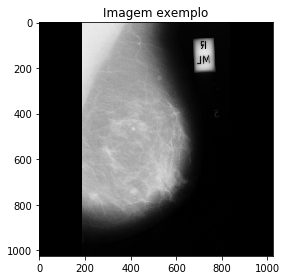

In [89]:
image = image_path[random.randint(0, len(image_path))]
plt.imshow(cv2.imread(image), cmap = "gray")
plt.title("Imagem exemplo")
plt.tight_layout()

### Normalização

In [0]:
def normalize(img):
  
   """Retorna a imagem normalizada. Com valores entre 0 e 1"""
  
   return img/255

### Verificação da dimensão da imagem:

In [91]:
print(cv2.imread(image).shape)

(1024, 1024, 3)


Observaçoes:

1.   Tamanho da imagem checado 1024x1024
2.   A imagem está em rgb, apesar de não parecer e deve ser alterada para escala de cinza
3. Como a mudança para escala de cinza é de caráter técnico não será feita nova visualização da imagem em escala de cinza


### Escala de cinza

In [0]:
def grayscale(img):
  
  """Dada uma imagem de entrada(img) retorna a mesma imagem em escala de cinza"""
  
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Normalização Global 

Procedimento padrão em se tratando de imagens de ultrassom é normalização global, definido a seguir. Como a normalização não altera a visualização da imagem sendo de caráter técnico não será exibida uma nova imagem.

In [0]:
def gcn(img):
  
  """Dada uma imagem retorna a mesma normalizada globalmente"""
  h,w=img.shape
  img=img - sum(img)/(h*w)
  return img

### Recorte das bordas

Definindo a função que recorta as bordas de uma imagem em escala de cinza:

In [0]:
def cropped_image(img, width_cut, height_cut):
  
  """Dada uma imagem  de entrada(img), o tamanho do corte nas bordas com relação
  a altura ( height_cut) e o tamanho do corte nas bordas com relação ao
  comprimento(width_cut), retorna a imagem cortada. Uma verificação é feita no
  tamanho do corte que não pode exceder o tamanho da imagem para evitar inconsistências."""
  
  height_img, width_img = img.shape  
  
  if width_cut*2 < width_img and height_cut*2 < height_img:  
    
    cropped_img=img[height_cut:height_img-height_cut,width_cut:width_img-width_cut]

  return cropped_img

Visualização de uma imagem cortada em 32 pixels na altura e no comprimento:

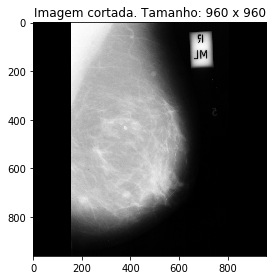

In [95]:
image2= cv2.imread(image)
image2 = grayscale(image2)
image2=cropped_image(image2,32,32)


title_size = "Imagem cortada. Tamanho: {} x {}".format(str(image2.shape[1]),str(image2.shape[0]))
plt.title( title_size)

plt.imshow(image2, cmap = "gray")
plt.tight_layout()

### Equalização da imagem

Definindo a função que faz a equalização da imagem:

In [0]:
def equalize(img):
  return cv2.equalizeHist(img)

Visualizando uma imagem equalizada:

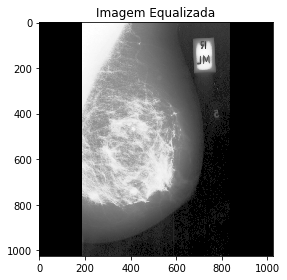

In [97]:
image2 = image
image2=cv2.imread(image2)
image2 = grayscale(image2)
image2 = equalize(image2)

plt.title('Imagem Equalizada')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()
  

### Intensidade da imagem

Definindo a função que procura pontos de intensidade num intervalo de 0 a 1, onde 0 é preto e 1 é branco:

In [0]:
def intensity_points(img,n_min,n_max):
  
  """Entradas img: nome da imagem
     nmin: intensidade mínima desejada
     n_max: intensidade máxima desejada
     Retorna uma imagem com gradação entre o mínimo e o máximo
     A imgem não pode estar normalizada ou a função deve ser ajustada!
  """
  
  img_intensity=[]
  
  height,width = img.shape
  total = height*width
  img=img.reshape(total)
  
  for i in range(total):
    if img[i]>255*n_min and img[i]<255*n_max :
      img_intensity.append(img[i])
    else:
      img_intensity.append(0)
  
  return np.asarray(img_intensity).reshape(height,width)

Visualizando uma imagem selecionando a intensidade entre 0.3 e 1

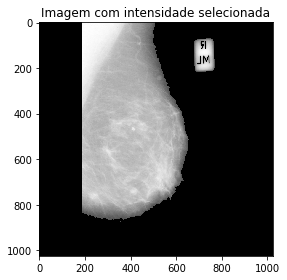

In [99]:
image2 = image
image2 = cv2.imread(image2)
image2 = grayscale(image2)
image2 = intensity_points(image2,0.3,1)

plt.title('Imagem com intensidade selecionada')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

### Maior objeto

Definindo a função que pega o maior objeto da imagem para eliminar as anotações de esquerda e direita(por exemplo):

In [0]:
def get_great(img):
  
  """Função que seleciona o maior objeto da imagem"""
    
  threshold = 0.25

# transformar imagem em binary com o threshol
  ret,thresh1 = cv2.threshold(img, threshold*255,255,cv2.THRESH_BINARY)

# funcao que pega maior objeto da imagem
  def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    img2 = np.int8(img2)
    return(img2)


  imagem_corrigida = undesired_objects(thresh1)

  merged = cv2.bitwise_and(img, img , mask=imagem_corrigida)

  return merged

Visualizando uma imagem depois de aplicar o procedimento de pegar o maior objeto(mama)

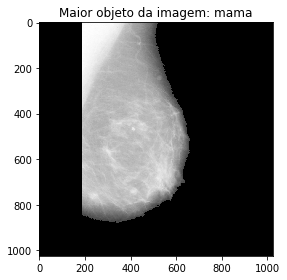

In [101]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)
image2 = get_great(image2)

plt.title('Maior objeto da imagem: mama')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()


Definindo uma função que retorna o centro do maior objeto da imagem:

In [0]:
def get_great_center(img):
  
  height_img, width_img = img.shape
  
  """Função que dada uma imagem seleciona o maior objeto e retorna
  o centro desse objeto"""
    
  threshold = 0.25

# transformar imagem em binary com o threshol
  ret,thresh1 = cv2.threshold(img, threshold*255,255,cv2.THRESH_BINARY)

# funcao que pega maior objeto da imagem
  def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    
    
    ch,cw =centroids[0]    
    
    ch = int(ch)
    cw=int(cw)    

    return ch,cw


  ch,cw = undesired_objects(thresh1)

  return ch,cw

Testando a função:

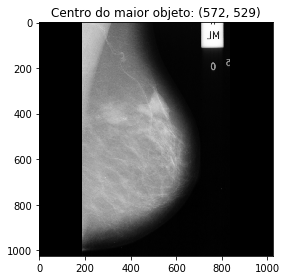

In [42]:
image = image_path[random.randint(0, len(image_path))]
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

center = str(get_great_center(image2))

plt.imshow(image2, cmap = "gray")
plt.title("Centro do maior objeto: " + center)
plt.tight_layout()


### Quadrados inscritos: possibilidade ; seleção ; recorte

Definindo uma função que verifica se em uma imagem com um determinado centro é possível inscrever um quadrado de um tamanho específico.

In [0]:
def square_possible(img, center_h, center_w, size):
  
  """Dada uma imagem (img) e as coordenadas de um ponto(center_h, center_w).
  A função retorna True se for possível inscrever um quadrado de tamanho(size)
  na imagem a partir desse ponto ou False, caso contrário."""
  
  height_img, width_img = img.shape 
  
  dist_centerh_bord = min(center_h, height_img-center_h)
  dist_centerw_bord = min(center_w, width_img-center_w)
  
  if dist_centerh_bord>=size/2 and dist_centerw_bord>=size/2:
    possible=True
  else:
    possible = False
  
  return possible

Verificando o funcionamento da função:

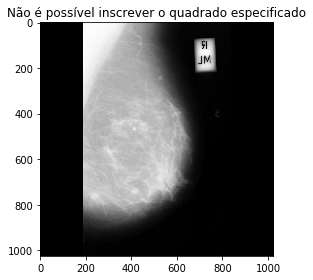

In [103]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

quadrado = square_possible(image2,200,200,401)

if quadrado:
  title_square='É possível inscrever o quadrado especificado'
else:
  title_square='Não é possível inscrever o quadrado especificado'

plt.title(title_square)
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

Definindo uma função que seleciona um quadrado em uma imagem de um tamanho específico a partir do centro quando for possível. Se não for possível retorna o maior quadrado possível a partir desse centro.

In [0]:
def select_square(img, center_h,center_w,size):
  
  """Dada uma imagem(img) as coordenadas do centro (center_h,center_w),
  e o tamanho do quadrado(size). A função retorna a imagem apenas com a seleção
  do quadrado. Se não for possível encontrar um quadrado de tamanho size, a função
  retorna o maioor quadrado possível"""
   
  while not square_possible(img,center_h,center_w,size):
    size-=1
    
  size=int(size)
    
  if size%2!=0:
    size-=1
  
  img2=img.copy()
  
  halfsize=size/2
  
  height_img, width_img = img.shape
  
  h_min,  h_max=  center_h - halfsize,center_h + halfsize
  w_min,  w_max=  center_w - halfsize,center_w + halfsize
 
  for i in range(height_img):
    for j in range(width_img):
      if i < h_min or i > h_max or j<w_min or j>w_max:
        img2[i,j]=0
  
  return img2

Verificando o funcionamento da função:

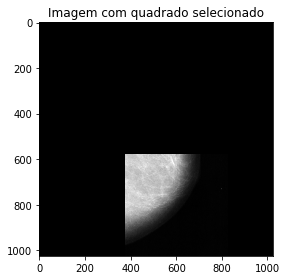

In [46]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

image2 = select_square(image2,800,600,800)

plt.title('Imagem com quadrado selecionado')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

Definindo uma função que recorta um quadrado em uma imagem de um tamanho específico a partir do centro quando for possível. Se não for possível retorna o maior quadrado possível a partir desse centro.

In [0]:
def select_square_crop(img, center_h,center_w,size):
  
  """Dada uma imagem(img) as coordenadas do centro (center_h,center_w),
  e o tamanho do quadrado(size). A função retorna a imagem apenas com o recorte
  do quadrado. Se não for possível encontrar um quadrado de tamanho size, a função
  retorna o maior quadrado possível"""
  
   
  while not square_possible(img,center_h,center_w,size):
    size-=1
    
  if size%2!=0:
    size-=1
  
    
  halfsize=size/2
  
  height_img, width_img = img.shape
  
  h_min,  h_max=  int(center_h - halfsize),int(center_h + halfsize)
  w_min,  w_max=  int(center_w - halfsize),int(center_w + halfsize)
 
  img2=np.zeros((size,size))
  
  img2[:,:]=img[h_min:h_max,w_min:w_max]
  

  return img2

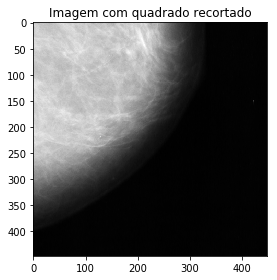

In [48]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

image2 = select_square_crop(image2,800,600,800)

plt.title('Imagem com quadrado recortado')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

### Todo o processamento

Definindo uma função que faz os processamentos na ordem desejada:

In [0]:
def preprocess(img,xc,yc,r):
  
  
  """Dada uma imagem, o centro da anormalidade e o raio,
  retorna a região de interesse."""
  
  r = int(r)
  
  if r<45:
    r=r+10
    
  if r>120:
    r=120
  
    
  img = cv2.imread(img)
  img = grayscale(img)  
  himg,wimg = img.shape
  
  hc = himg - int(yc)
  hc = int(hc)
  wc = int(xc)  
  
  img = select_square_crop(img,hc,wc,r)     
  img = intensity_points(img,0.3,1)
  img = normalize(img)
  img = cv2.resize(img,(100,100))    
 
  
  return img

Visualizando uma imagem pré processada:

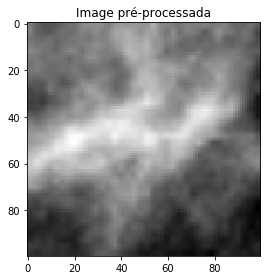

In [110]:
number = random.randint(0, len(image_paths)-1)

         
                        
image3 = image_paths[number]
xc,yc,r = x_coord[number], y_coord[number],radius[number]                       
                        
image2 = preprocess(image3,xc,yc,r)

plt.title('Image pré-processada')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()





---


## Testes 1


---



Fim do pré-processamento. Realização de teste testes para verificar as imagens antes e depois dessa etapa. 

Exibindo todas as imagens processadas:

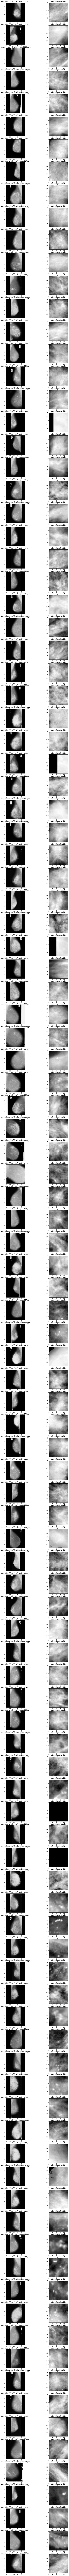

In [111]:
ncol = 2
nrow = 113


fig, axs = plt.subplots(nrow,ncol, figsize=(10,300))
fig.tight_layout()

for i in range(nrow):  
  
  number = i   
  image = image_paths[number]
  
  xc,yc,r = x_coord[number], y_coord[number],radius[number] 
  
  image_original = cv2.imread(image)
  image_original = cv2.resize(image_original,(100,100))
  
  image_process= preprocess(image,xc,yc,r)
  
  for j in range(ncol):     
    
    
    axs[i][0].imshow(image_original,cmap='gray')
    axs[i][1].imshow(image_process,cmap='gray')
    
    axs[i][0].set_title('Imagem original: ' + str(image_paths[number]))
    axs[i][1].set_title('Imagem processada')
      

    

 Como observado visualmente as seguintes imagens : 
 
1. mdb072
2. mdb110
3. mdb126
4. mdb212
5. mdb214

Não apresentam o centro da anormalidade e serão excluídas. 

Esses erro provavelmente são falhas de anotação, uma troca de eixo, uma desatenção na hora de anotar o diagnóstico pode comprometer a qualidade/quantidade de imagens do banco. 

Removendo registros da lista_problemas:

In [0]:
lista_problemas=['mdb072.pgm','mdb110.pgm','mdb126.pgm','mdb212.pgm','mdb214.pgm']

data_problema=pd.DataFrame()

for i in range(len(lista_problemas)):
  data2 = data.loc[data['Image'] == lista_problemas[i]]
  data_problema = pd.concat([data_problema,data2])
  
list_centers=data_problema[:].index
data = data.drop(list_centers)

Verificando o tamanho de data:

In [113]:
len(data)

108

## Atualização das entradas do banco

In [0]:
y= np.asarray(data['Severity_M'])

x_coord, y_coord,radius= np.asarray(data['x_coordinate'][:]),np.asarray(data['y_coordinate'][:]),np.asarray( data['radius'][:])

image_path =[]

for img in data['Image'][:]:
  image_path.append( os.path.join(datadir2, img))
  
image_paths=np.asarray(image_path)

Adicionando em image_paths o endereço da imagem, centro, e raio:

In [0]:
image_paths = np.concatenate((image_paths.reshape(len(data),1), x_coord.reshape(len(data),1),y_coord.reshape(len(data),1),radius.reshape(len(data),1)), axis=1)

## Testes 2

Visualizando todas as imagens do banco pré-processadas:

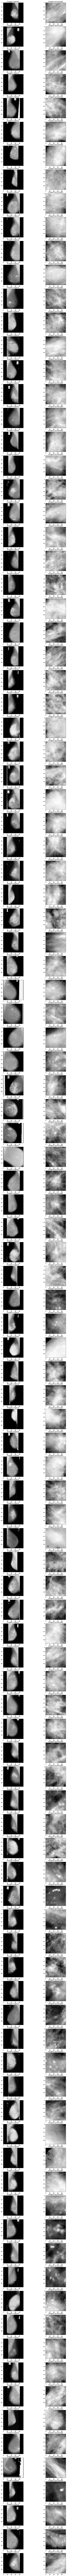

In [120]:
ncol = 2
nrow = len(data)

fig, axs = plt.subplots(nrow,ncol, figsize=(10,300))
fig.tight_layout()

for i in range(nrow):
  
  
  number = i    
  image = image_paths[number]
  
    
  image_original = cv2.imread(image[0])
  image_original = cv2.resize(image_original,(100,100))  
  image_process= preprocess(image[0],int(image[1]),int(image[2]),int(image[3]))
  
  for j in range(ncol):      
    
    
    axs[i][0].imshow(image_original,cmap='gray')
    axs[i][1].imshow(image_process,cmap='gray')
    
    axs[i][0].set_title('Imagem original: ')
    axs[i][1].set_title('Imagem processada')